# MS SSIM
----

This notebook begins the creation of the data sets necessary to train the MS_SSIM network. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
np.set_printoptions(threshold=np.nan)
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

In [2]:
def calculate_contrast(window_orig, window_recon):
    '''
    calculates the contrast metric for a given window of two images
    '''
    k_2, L = 0.03, 255
    c_2 = (L*k_2)**2
    
    orig_data, recon_data = window_orig.flatten(), window_recon.flatten()
    var_x, var_y = np.var(recon_data), np.var(orig_data)
    
    num = 2*np.sqrt(var_x)*np.sqrt(var_y) + c_2
    den = var_x + var_y + c_2
    
    return num/den

def calculate_structure(window_orig, window_recon):
    '''
    calculates the structure metric for a given window of two images
    '''
    k_2, L = 0.03, 255
    c_2 = (L*k_2)**2
    c_3 = c_2 / 2
    
    orig_data, recon_data = window_orig.flatten(), window_recon.flatten()
    std_x, std_y = np.std(recon_data), np.std(orig_data)
    covar = np.cov(orig_data, recon_data)[0][1]
    
    num = covar + c_3
    den = std_x * std_y + c_3
    
    return num/den

Now that we have the metrics in place we can load the data an run them iteratively at each size of the images.

In [3]:
raw_image_dim, filter_dim = 96, 11
train_size, test_size = 500, 140

In [4]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500_raw = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500_raw = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140_raw = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140_raw = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

In [5]:
# reshape
orig_500 = np.reshape(orig_500_raw.values, (train_size, raw_image_dim, raw_image_dim))
recon_500 = np.reshape(recon_500_raw.values, (train_size, raw_image_dim, raw_image_dim))
orig_140 = np.reshape(orig_140_raw.values, (test_size, raw_image_dim, raw_image_dim))
recon_140 = np.reshape(recon_140_raw.values, (test_size, raw_image_dim, raw_image_dim))

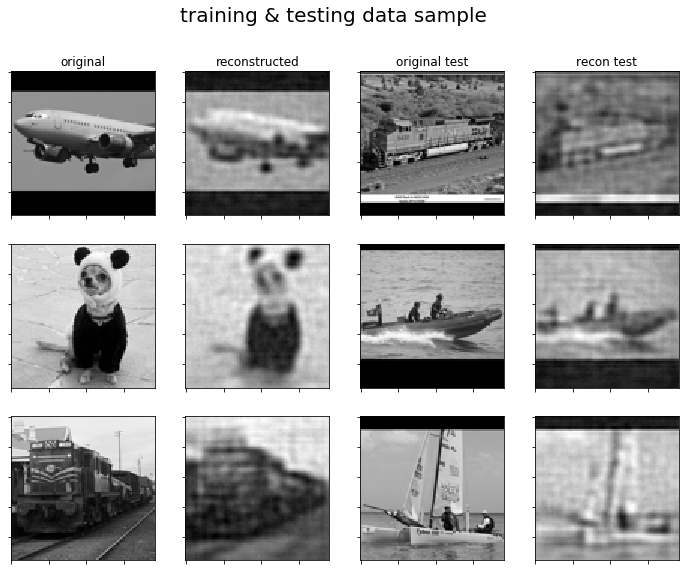

In [54]:
# make sure pictures look right
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    index = np.random.randint(140)
    axarr[i,0].imshow(orig_500[index,:,:], cmap='gray')
    axarr[i,1].imshow(recon_500[index,:,:], cmap='gray')
    axarr[i,2].imshow(orig_140[index,:,:], cmap='gray')
    axarr[i,3].imshow(recon_140[index,:,:], cmap='gray')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[0,2].set_title('original test')
axarr[0,3].set_title('recon test')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('training & testing data sample', size=20)
# plt.savefig('tt_data_sample.png')
plt.show()

data looks good. now we can get the contrast and structures for the full size images.

In [7]:
def image_contrast(orig_im, recon_im):
    '''
    gets the contrast for each patch of a set of images.
    '''
    contrast_res = []
    number_windows = orig_im.shape[0] - filter_dim + 1
    for i in range(number_windows):
        for j in range(number_windows):
            orig_window = orig_im[i:i+11, j:j+11]
            recon_window = recon_im[i:i+11, j:j+11]
            temp = calculate_contrast(orig_window, recon_window)
            contrast_res.append(temp)
    return np.reshape(contrast_res, (number_windows, number_windows))

def image_structure(orig_im, recon_im):
    '''
    gets the structure for each patch of a set of images.
    '''
    structure_res = []
    number_windows = orig_im.shape[0] - filter_dim + 1
    for i in range(number_windows):
        for j in range(number_windows):
            orig_window = orig_im[i:i+11, j:j+11]
            recon_window = recon_im[i:i+11, j:j+11]
            temp = calculate_structure(orig_window, recon_window)
            structure_res.append(temp)
    return np.reshape(structure_res, (number_windows, number_windows))

Lets test these functions on a couple images and see how they look.

In [8]:
contrast_res, structure_res = [], []
indeces = []
for ii in range(3):
    index = np.random.randint(140)
    indeces.append(index)
    temp_im_orig = orig_500[index,:,:]
    temp_im_recon = recon_500[index,:,:]
    contrast_res.append(image_contrast(temp_im_orig, temp_im_recon))
    structure_res.append(image_structure(temp_im_orig, temp_im_recon))
contrast_res = np.asarray(contrast_res)
structure_res = np.asarray(structure_res)

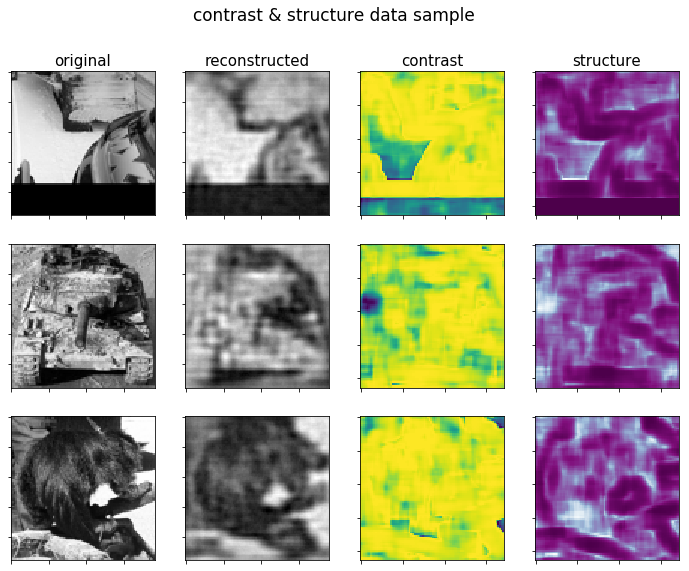

In [9]:
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    axarr[i,0].imshow(orig_500[indeces[i],:,:], cmap='gray')
    axarr[i,1].imshow(recon_500[indeces[i],:,:], cmap='gray')
    axarr[i,2].imshow(contrast_res[i,:,:], cmap='viridis')
    axarr[i,3].imshow(structure_res[i,:,:], cmap='BuPu')

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('reconstructed', size=15)
axarr[0,2].set_title('contrast', size=15)
axarr[0,3].set_title('structure', size=15)
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('contrast & structure data sample', size=17)
# plt.savefig('contrast_structure_data_sample.png')
plt.show()

This looks pretty good. Now lets do some down sampling and see how those look

In [10]:
def average_pool(window):
    return np.mean(window)

In [11]:
def down_sample(orig_im, recon_im, pool_size):
    '''
    down samples image by a factor of pool_size
    '''
    reduce_im_orig, reduce_im_recon = [], []
    number_pools = int(orig_im.shape[0] / pool_size)
    for i in range(number_pools):
        for j in range(number_pools):
            orig_pool = orig_im[i*pool_size:i*pool_size+pool_size, j*pool_size:j*pool_size+pool_size]
            recon_pool = recon_im[i*pool_size:i*pool_size+pool_size, j*pool_size:j*pool_size+pool_size]
            temp_orig, temp_recon = average_pool(orig_pool), average_pool(recon_pool)
            reduce_im_orig.append(temp_orig)
            reduce_im_recon.append(temp_recon)
            
    return np.reshape(reduce_im_orig, (number_pools,number_pools)), np.reshape(reduce_im_recon, (number_pools,number_pools))

In [12]:
down_sample_res = []
indeces = []
pool_size = 2
for ii in range(3):
    index = np.random.randint(140)
    indeces.append(index)
    temp_im_orig = orig_500[index,:,:]
    temp_im_recon = recon_500[index,:,:]
    down_sample_res.append(down_sample(temp_im_orig, temp_im_recon, pool_size))
down_sample_res = np.asarray(down_sample_res)

In [13]:
down_sample_res.shape

(3, 2, 48, 48)

Now that we have the downsampled images, we can run the structure and contrast functions on them again.

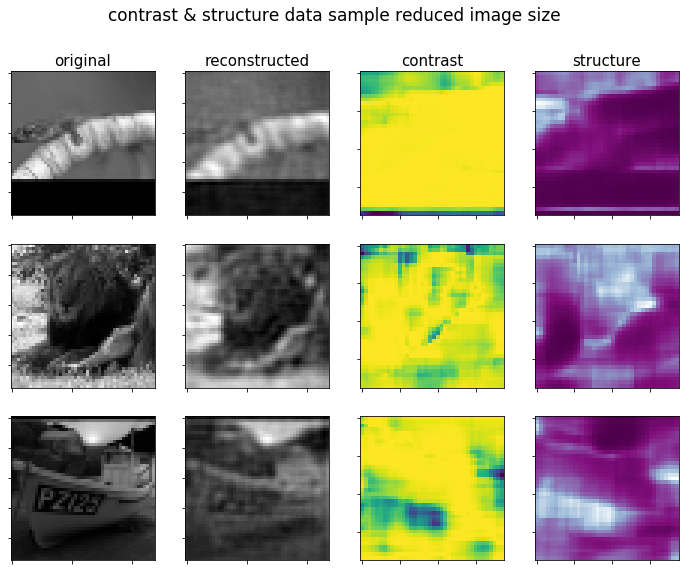

In [14]:
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    axarr[i,0].imshow(down_sample_res[i,0,:,:], cmap='gray')
    axarr[i,1].imshow(down_sample_res[i,1,:,:], cmap='gray')
    axarr[i,2].imshow(image_contrast(down_sample_res[i,0,:,:], down_sample_res[i,1,:,:]), cmap='viridis')
    axarr[i,3].imshow(image_structure(down_sample_res[i,0,:,:], down_sample_res[i,1,:,:]), cmap='BuPu')

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('reconstructed', size=15)
axarr[0,2].set_title('contrast', size=15)
axarr[0,3].set_title('structure', size=15)
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('contrast & structure data sample reduced image size', size=17)
# plt.savefig('contrast_structure_data_sample_red1.png')
plt.show()

One more down sampling will be done when we do the ms ssim scores so lets just take a look at one more level. 

In [15]:
down_sample_res = []
indeces = []
pool_size = 2
for ii in range(3):
    index = np.random.randint(140)
    indeces.append(index)
    temp_im_orig = orig_500[index,:,:]
    temp_im_recon = recon_500[index,:,:]
    one_ds = down_sample(temp_im_orig, temp_im_recon, pool_size)
    two_ds = down_sample(one_ds[0], one_ds[1], pool_size)
    down_sample_res.append(two_ds)
down_sample_res = np.asarray(down_sample_res)

In [16]:
down_sample_res.shape

(3, 2, 24, 24)

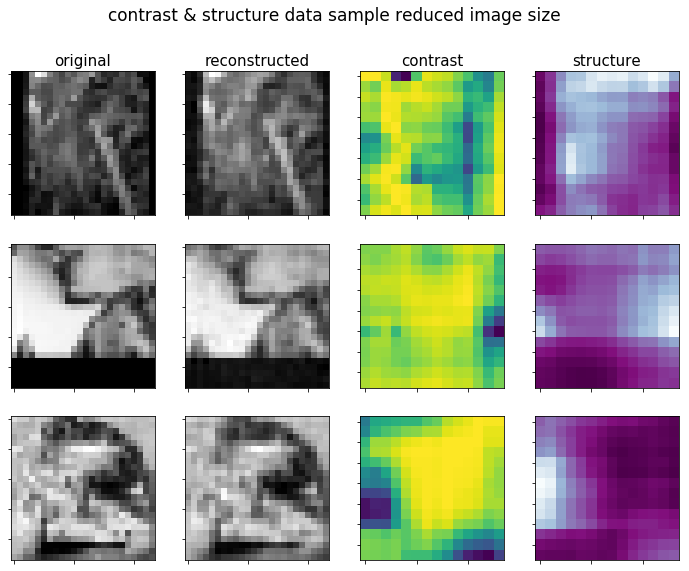

In [17]:
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    axarr[i,0].imshow(down_sample_res[i,0,:,:], cmap='gray')
    axarr[i,1].imshow(down_sample_res[i,1,:,:], cmap='gray')
    axarr[i,2].imshow(image_contrast(down_sample_res[i,0,:,:], down_sample_res[i,1,:,:]), cmap='viridis')
    axarr[i,3].imshow(image_structure(down_sample_res[i,0,:,:], down_sample_res[i,1,:,:]), cmap='BuPu')

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('reconstructed', size=15)
axarr[0,2].set_title('contrast', size=15)
axarr[0,3].set_title('structure', size=15)
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('contrast & structure data sample reduced image size', size=17)
# plt.savefig('contrast_structure_data_sample_red2.png')
plt.show()

A lot of the information is lost when the images are so small, but so it goes. Now the last componenet of the ms ssim calculation is the luminance scale which is calclulated at the lowest resolution used (24x24) in this case. 

In [18]:
def calculate_luminance(window_orig, window_recon):
    '''
    calculates the contrast metric for a given window of two images
    '''
    k_1, L = 0.01, 255
    c_1 = (L*k_1)**2
    
    orig_data, recon_data = window_orig.flatten(), window_recon.flatten()
    mean_x, mean_y = np.mean(recon_data), np.mean(orig_data)
    
    num = 2*mean_x*mean_y + c_1
    den = np.square(mean_x)+ np.square(mean_y) + c_1
    
    return num/den


def image_luminance(orig_im, recon_im):
    '''
    gets the contrast for each patch of a set of images.
    '''
    luminance_res = []
    number_windows = orig_im.shape[0] - filter_dim + 1
    for i in range(number_windows):
        for j in range(number_windows):
            orig_window = orig_im[i:i+11, j:j+11]
            recon_window = recon_im[i:i+11, j:j+11]
            temp = calculate_luminance(orig_window, recon_window)
            luminance_res.append(temp)
    return np.reshape(luminance_res, (number_windows, number_windows))

Lets check luminance on the larger images to make sure it is sensible.

In [19]:
luminance_res = []
indeces = []
for ii in range(3):
    index = np.random.randint(140)
    indeces.append(index)
    temp_im_orig = orig_500[index,:,:]
    temp_im_recon = recon_500[index,:,:]
    luminance_res.append(image_luminance(temp_im_orig, temp_im_recon))
luminance_res = np.asarray(luminance_res)

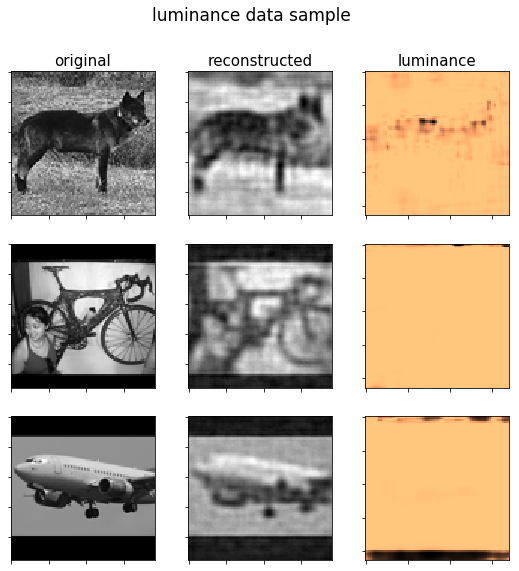

In [20]:
f, axarr = plt.subplots(nrows=3,ncols=3, figsize=(9,9))
for i in range(3):
    axarr[i,0].imshow(orig_500[indeces[i],:,:], cmap='gray')
    axarr[i,1].imshow(recon_500[indeces[i],:,:], cmap='gray')
    axarr[i,2].imshow(luminance_res[i,:,:], cmap='copper')

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('reconstructed', size=15)
axarr[0,2].set_title('luminance', size=15)
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('luminance data sample', size=17)
# plt.savefig('luminance_data_sample.png')
plt.show()

Not really what i expected, but it looks right. Now lets do it for the lowest resolution images.

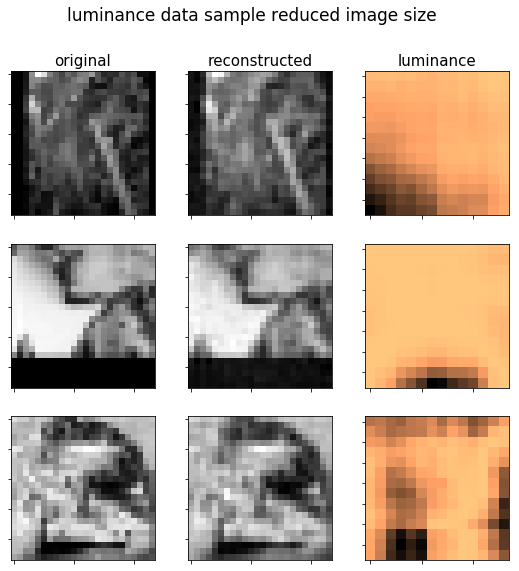

In [21]:
f, axarr = plt.subplots(nrows=3,ncols=3, figsize=(9,9))
for i in range(3):
    axarr[i,0].imshow(down_sample_res[i,0,:,:], cmap='gray')
    axarr[i,1].imshow(down_sample_res[i,1,:,:], cmap='gray')
    axarr[i,2].imshow(image_luminance(down_sample_res[i,0,:,:], down_sample_res[i,1,:,:]), cmap='copper')

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('reconstructed', size=15)
axarr[0,2].set_title('luminance', size=15)
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('luminance data sample reduced image size', size=17)
# plt.savefig('luminance_data_sample_red2.png')
plt.show()

----- 
paper plot

In [83]:
index = 269
sample_image_orig = orig_500[index,:,:]; sample_image_recon = recon_500[index,:,:];

sample_image_con = image_contrast(sample_image_orig,sample_image_recon)
sample_image_str = image_contrast(sample_image_orig,sample_image_recon)

sample_image_orig_ds1, sample_image_recon_ds1 = down_sample(sample_image_orig, sample_image_recon, 2)

sample_image_con_ds1 = image_contrast(sample_image_orig_ds1,sample_image_recon_ds1)
sample_image_str_ds1 = image_contrast(sample_image_orig_ds1,sample_image_recon_ds1)

sample_image_orig_ds2, sample_image_recon_ds2 = down_sample(sample_image_orig_ds1, sample_image_recon_ds1, 2)

sample_image_con_ds2 = image_contrast(sample_image_orig_ds2,sample_image_recon_ds2)
sample_image_str_ds2 = image_contrast(sample_image_orig_ds2,sample_image_recon_ds2)

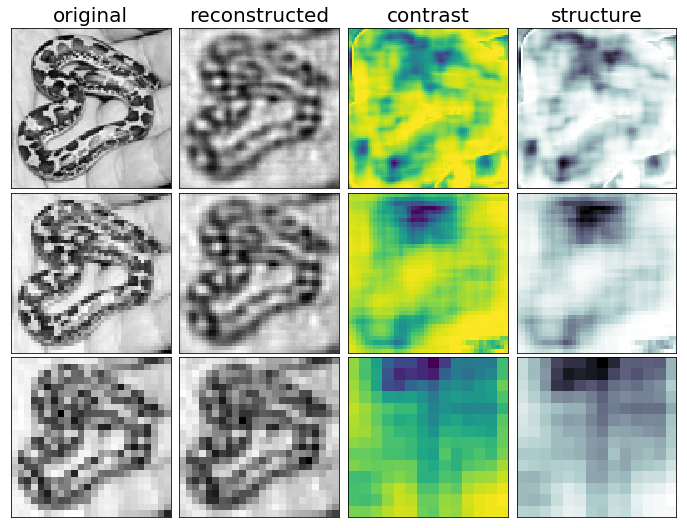

In [85]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (12,9))
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.03, hspace=0.03)

ax_dict = {}
for ii in range(12):
    ax_dict[ii] = plt.subplot(gs1[ii])
    ax_dict[ii].set_xticklabels([])
    ax_dict[ii].set_yticklabels([])
    ax_dict[ii].get_xaxis().set_visible(False)
    ax_dict[ii].get_yaxis().set_visible(False)

ax_dict[0].set_title('original', size=20)
ax_dict[1].set_title('reconstructed', size=20)
ax_dict[2].set_title('contrast', size=20)
ax_dict[3].set_title('structure', size=20)

ax_dict[0].imshow(sample_image_orig, cmap='gray')
ax_dict[1].imshow(sample_image_recon, cmap='gray')
ax_dict[2].imshow(sample_image_con, cmap='viridis')
ax_dict[3].imshow(sample_image_str, cmap='bone')

ax_dict[4].imshow(sample_image_orig_ds1, cmap='gray')
ax_dict[5].imshow(sample_image_recon_ds1, cmap='gray')
ax_dict[6].imshow(sample_image_con_ds1, cmap='viridis')
ax_dict[7].imshow(sample_image_str_ds1, cmap='bone')

ax_dict[8].imshow(sample_image_orig_ds2, cmap='gray')
ax_dict[9].imshow(sample_image_recon_ds2, cmap='gray')
ax_dict[10].imshow(sample_image_con_ds2, cmap='viridis')
ax_dict[11].imshow(sample_image_str_ds2, cmap='bone')

plt.savefig('data_sample_msssim.png')
plt.show()

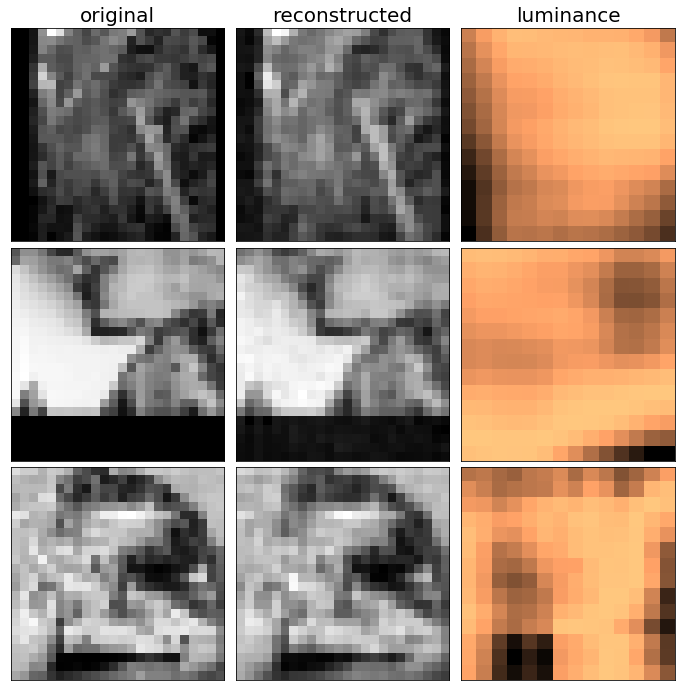

In [91]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (12,12))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.03, hspace=0.03)

ax_dict = {}
for ii in range(9):
    ax_dict[ii] = plt.subplot(gs1[ii])
    ax_dict[ii].set_xticklabels([])
    ax_dict[ii].set_yticklabels([])
    ax_dict[ii].get_xaxis().set_visible(False)
    ax_dict[ii].get_yaxis().set_visible(False)

for ii in range(3):
    ax_dict[3*ii].imshow(down_sample_res[ii,0,:,:], cmap='gray')
    ax_dict[3*ii+1].imshow(down_sample_res[ii,1,:,:], cmap='gray')
    ax_dict[3*ii+2].imshow(image_luminance(down_sample_res[i,0,:,:], down_sample_res[ii,1,:,:]), cmap='copper')

ax_dict[0].set_title('original', size=20)
ax_dict[1].set_title('reconstructed', size=20)
ax_dict[2].set_title('luminance', size=20)
plt.savefig('lum.png')
plt.show()

Now we have all the compnents of ms ssim. Now we can create the data sets we need in order to train the network. First lets create a full size image version of contrast times structure. 

In [22]:
# contrast_res, structure_res = [], []
# bar = progressbar.ProgressBar()
# for ii in bar(range(140)):
#     temp_im_orig = orig_140[ii,:,:]
#     temp_im_recon = recon_140[ii,:,:]
#     contrast_res.append(image_contrast(temp_im_orig, temp_im_recon))
#     structure_res.append(image_structure(temp_im_orig, temp_im_recon))
# contrast_res = np.asarray(contrast_res)
# structure_res = np.asarray(structure_res)

In [23]:
# luminance_res = []
# bar = progressbar.ProgressBar()
# for ii in bar(range(140)):
#     temp_im_orig = orig_140[ii,:,:]
#     temp_im_recon = recon_140[ii,:,:]
#     luminance_res.append(image_luminance(temp_im_orig, temp_im_recon))
# luminance_res = np.asarray(luminance_res)

In [24]:
# np.savetxt('luminance_140.csv', np.reshape(luminance_res, (140, 7396)), delimiter=',')

In [25]:
# np.savetxt('contrast_500.csv', np.reshape(contrast_res, (140, 7396)), delimiter=',')
# np.savetxt('structure_500.csv', np.reshape(structure_res, (140, 7396)), delimiter=',')
# np.savetxt('cxs_500.csv', np.reshape(contrast_res*structure_res, (140, 7396)), delimiter=',')

In [26]:
# down_sample_res = []
# pool_size = 2
# bar = progressbar.ProgressBar()
# for ii in bar(range(140)):
#     temp_im_orig = orig_140[ii,:,:]
#     temp_im_recon = recon_140[ii,:,:]
#     one_ds = down_sample(temp_im_orig, temp_im_recon, pool_size)
#     two_ds = down_sample(one_ds[0], one_ds[1], pool_size)
#     down_sample_res.append(two_ds)
# down_sample_res = np.asarray(down_sample_res)

In [27]:
# down_sample_res.shape

In [28]:
# luminance_res = []
# bar = progressbar.ProgressBar()
# for ii in bar(range(140)):
#     temp_im_orig = down_sample_res[ii,0,:,:]
#     temp_im_recon = down_sample_res[ii,1,:,:]
#     luminance_res.append(image_luminance(temp_im_orig, temp_im_recon))
# luminance_res = np.asarray(luminance_res)

In [29]:
# np.savetxt('luminance_140.csv', np.reshape(luminance_res, (140, 14*14)), delimiter=',')

In [30]:
# ds2_orig = down_sample_res[:,0,:,:]
# ds2_recon = down_sample_res[:,1,:,:]

In [31]:
# np.savetxt('ds2_orig_140.csv', np.reshape(ds2_orig, (140, 24*24)), delimiter=',')
# np.savetxt('ds2_recon_140.csv', np.reshape(ds2_recon, (140, 24*24)), delimiter=',')